# Calculator for project's financials

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import math

In [ ]:
electricity_consumption = 30 #kWh daily usage
panel_efficiency = 0.15 #%
solar_radiation = 6.0 #kWh/m2/day
degradation = 0.9 #at 10 years?
price_per_watt = 5 
electricity_consumption_percentage = 0.8
DCtoACLoss = 0.2
STC_power_rating = 260 #W
length = 1665
width = 991
warranty = 25
ElectricityPriceUCDemand = 0.15

In [59]:
#test for Unit test of SEI
electricity_consumption = 30 #kWh daily usage
panel_efficiency = 0.156 #%
solar_radiation = 5.0 #kWh/m2/day
degradation = 0.9 #at 10 years?
price_per_watt = 3 #after incentives  
electricity_consumption_percentage = 1.0 # options are {0.8, 1.0}
DCtoACLoss = 0.2
STC_power_rating = 260 #W
length = 1665
width = 991
warranty = 25
ElectricityPriceUCDemand = 0.20
tax_incentive = 0.3


#tiered pricing 

#lease terms 
# 'transaction price' or 'capitalized cost'
# 'residual value'
# interest rate of the lease 
# length of the lease 
# monthly payment of the lease 
#lease terms
interest_rate_lease = 0.04 
lease_rate_escalation = 0.02 #specific for the lease terms
lease_length = 25
residual_value = 0.1 #percent of the initial value

#loan terms
interest_rate_loan = 0.06
loan_length = 15


#market terms
market_interest_rate = 0.02
inflation = 0.02 


In [55]:
#Scenario 1 for explanations sheet 
electricity_consumption = 20 #kWh daily usage
panel_efficiency = 0.156 #%
solar_radiation = 5.0 #kWh/m2/day
degradation = 0.9 #at 10 years?
price_per_watt = 3 #after incentives  - medium range quality
electricity_consumption_percentage = 2.0 # 
DCtoACLoss = 0.2
STC_power_rating = 260 #W
length = 1665
width = 991
warranty = 25 #change to 20 and propagate
ElectricityPriceUCDemand = 0.20
tax_incentive = 0.3


#tiered pricing 

#lease terms 
# 'transaction price' or 'capitalized cost'
# 'residual value'
# interest rate of the lease 
# length of the lease 
# monthly payment of the lease 
#lease terms
interest_rate_lease = 0.04 
lease_rate_escalation = 0.02 #specific for the lease terms
lease_length = 25
residual_value = 0.1 #percent of the initial value

#loan terms
interest_rate_loan = 0.06
loan_length = 15


#market terms
market_interest_rate = 0.02
inflation = 0.02 

In [78]:
#Scenario 2 for explanations sheet 
electricity_consumption = 30 #kWh daily usage
panel_efficiency = 0.20 #%
solar_radiation = 5.0 #kWh/m2/day
degradation = 0.9 #at 10 years?
price_per_watt = 4 #after incentives  
electricity_consumption_percentage = 1.0 #  
DCtoACLoss = 0.2
length = 1665
width = 991
warranty = 25
ElectricityPriceUCDemand = 0.20
tax_incentive = 0.3


#technical parameters - calculated(could be stated if double check is needed)
STC_power_rating = panel_efficiency * length * width / 1000
#print(STC_power_rating)

#tiered pricing 

#lease terms 
# 'transaction price' or 'capitalized cost'
# 'residual value'
# interest rate of the lease 
# length of the lease 
# monthly payment of the lease 
#lease terms
interest_rate_lease = 0.04 
lease_rate_escalation = 0.02 #specific for the lease terms
lease_length = 25
residual_value = 0.1 #percent of the initial value

#loan terms
interest_rate_loan = 0.06
loan_length = 15


#market terms
market_interest_rate = 0.02
inflation = 0.02 

In [5]:
#utility bill- double check for the current set of parameters
utility_bill_monthly = electricity_consumption * ElectricityPriceUCDemand * 365.25/12
print(utility_bill_monthly)

121.75


In [80]:
%%latex


UsageError: %%latex is a cell magic, but the cell body is empty.

In [44]:
def calculate_design():
   
    N_PANELS = math.ceil(electricity_consumption * electricity_consumption_percentage / \
                         ((solar_radiation) * panel_efficiency * (length * width/1000000) * ( 1 - DCtoACLoss)))
    DC_size = N_PANELS * STC_power_rating / 1000
    DC_size = min(10, DC_size)
    N_PANELS = DC_size * 1000 / STC_power_rating
    AC_size = DC_size * (1 - DCtoACLoss) 
    total_costs = price_per_watt * DC_size * 1000 #price per watt is after rebate
    area = length * width / 1000000 * N_PANELS
    
    #savings over lifetime
    #current efficiency
    efficiency_t = panel_efficiency
    total_savings = 0
    AC_size_t = AC_size
    degradation_t = math.exp(math.log(degradation)/10)
    years_to_payoff = 0
    flag_years_to_payoff = False
    potential_costs = 0.0
    
    #purchase financials
    NPV_purchase = - total_costs
    
    #loan payments
    loan_amount = total_costs 
    N_loan = loan_length * 12
    loan_annuity = (interest_rate_loan/12)/(1 - math.pow((1 + interest_rate_loan/12), -N_loan))*loan_amount
    
    #loan financials
    NPV_loan = 0.0
    
    #aggregate into yearly payments on the lease 
    #lease financials
    total_lease_payments = 0.0
    interest_rate_lease_t = interest_rate_lease
    
    #lease annuity payment in the beginning before escalation
    lease_annuity = interest_rate_lease * \
                    (total_costs - total_costs * residual_value / \
                    math.pow(1 + interest_rate_lease_t, lease_length)) / \
                    (1 - math.pow(1 + interest_rate_lease_t, - lease_length))
    #initial capitalized cost of the lease
    residual_value_t = total_costs
    NPV_lease = 0.0
    lease_payment_t = lease_annuity
    
    #initial electricity price
    ElectricityPriceUCDemand_t = ElectricityPriceUCDemand
    
    for i in range(warranty):
        #yearly production
        production_t = AC_size_t * solar_radiation * 365.25
        total_savings = total_savings + production_t * ElectricityPriceUCDemand_t
        AC_size_t = AC_size_t * degradation_t
        
        #NPV of a purchase
        NPV_purchase = NPV_purchase + production_t * ElectricityPriceUCDemand_t / math.pow(1 + market_interest_rate, i)
        
        #NPV loan income part
        NPV_loan = NPV_loan + (production_t * ElectricityPriceUCDemand_t) / math.pow(1 + market_interest_rate, i)
        
        #NPV lease income part
        NPV_lease = NPV_lease + (production_t * ElectricityPriceUCDemand_t) / math.pow(1 + market_interest_rate, i)
        
        
        if (i < loan_length):
            NPV_loan = NPV_loan - (loan_annuity * 12) / math.pow(1 + market_interest_rate, i)
        
        
        if (i < lease_length):
            #calculate principal and interest payment for the lease
            #interest payment for the lease at original interest rate
            interest_payment_lease_t = residual_value_t * interest_rate_lease
            
            #principal payment for the lease
            principal_payment_lease_t = (lease_annuity - interest_payment_lease_t)
            
            #new residual value
            residual_value_t = residual_value_t - principal_payment_lease_t
            
            #actual interest rate for the lease
            interest_rate_lease_t = (lease_payment_t - principal_payment_lease_t)/residual_value_t
            #print(interest_rate_lease_t)
            
            #NPV of a lease with escalation
            NPV_lease = NPV_lease - (lease_payment_t) / math.pow(1 + market_interest_rate, i)
        
            #total lease payments
            total_lease_payments = total_lease_payments + lease_payment_t
            
            #actual escalate lease payment for the next cycle
            lease_payment_t = lease_payment_t * (1 + lease_rate_escalation)
#            print(lease_payment_t/12)
            
            
        
        if (total_savings >= total_costs) and (not (flag_years_to_payoff)):
            flag_years_to_payoff = True
            years_to_payoff = i
         
        #potential costs with electricity price escalation
        potential_costs = potential_costs + electricity_consumption * 365.25 * ElectricityPriceUCDemand_t
        
        #escalation of electricity price
        ElectricityPriceUCDemand_t = ElectricityPriceUCDemand_t * (1 + inflation)
        
    #purchase payments
    percent_savings = total_savings / potential_costs
    net_savings_purchase = (total_savings - total_costs)/potential_costs    
#    print("{parameter} : {value_:8.2f}".format(parameter = 'Potential costs', value_ = potential_costs))
    
    
    #loan analysis
    net_savings_loan = (total_savings - loan_annuity * N_loan)/potential_costs
#    print("{parameter} : {value_:8.2f}".format(parameter = 'total loan payments', value_ = loan_annuity * N_loan))
#    print("{parameter} : {value_:8.2f}".format(parameter = 'monthly loan payment', value_ = loan_annuity))
#    print("{parameter} : {value_:8.2f}".format(parameter = 'N loan payments', value_ = N_loan))
    
    
    #lease analysis
    net_savings_lease = (total_savings - total_lease_payments)/potential_costs
#    print("{parameter} : {value_:8.2f}".format(parameter = 'total lease payments', value_ = total_lease_payments))
#    print("{parameter} : {value_:8.2f}".format(parameter = 'N lease payments', value_ = lease_length * 12))
    
        
    #IRR - maybe modified
        
    

    
 
    
    
    
    return {'N_PANELS':N_PANELS, 'DC_size':DC_size, 'AC_size':AC_size, 'total_costs':total_costs, \
           'area':area, 'total_savings':total_savings, 'percent_savings':percent_savings, \
            'net_savings_purchase':net_savings_purchase, \
            'NPV_purchase':NPV_purchase/DC_size/1000, \
            'net_savings_loan':net_savings_loan, \
            'NPV_loan':NPV_loan/DC_size/1000, \
            'net_savings_lease':net_savings_lease, \
            'NPV_lease':NPV_lease/DC_size/1000, \
            'years_to_payoff': years_to_payoff}



In [39]:
design = calculate_design()
for key, value in design.items():
    print("{parameter} : {value_:8.2f}".format(parameter = key, value_ = value))

DC_size :    15.34
NPV_loan :    -0.18
years_to_payoff :    15.00
percent_savings :     1.79
NPV_lease :    -1.25
net_savings_purchase :     0.70
N_PANELS :    59.00
AC_size :    12.27
area :    97.35
net_savings_lease :    -0.37
total_costs : 76700.00
NPV_purchase :     1.46
net_savings_loan :     0.13
total_savings : 125518.52


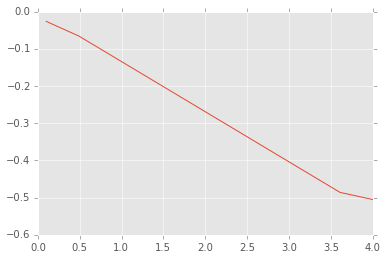

In [57]:
y = np.zeros(11)
x = np.zeros(11)
i = 0
#draw percent of a bill vs savings graph
for step in np.linspace(0.1, 4.0, num=11):
    electricity_consumption_percentage = step
    #call function, get percent_savings
    design = calculate_design()
    y[i] = design['net_savings_loan']
    x[i] = step
    i = i + 1
#draw graph
plt.plot(x, y)

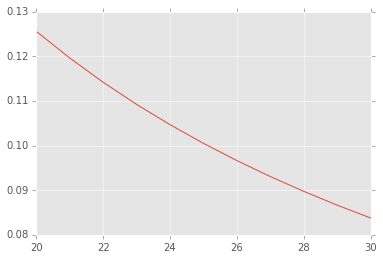

In [48]:
y = np.zeros(11)
x = np.zeros(11)
i = 0
#draw percent of a bill vs savings graph
for step in np.linspace(20, 30, num=11):
    electricity_consumption = step
    #call function, get percent_savings
    design = calculate_design()
    y[i] = design['net_savings_loan']
    x[i] = step
    i = i + 1
#draw graph
plt.plot(x, y)

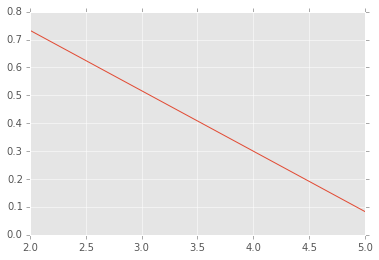

In [50]:
y = np.zeros(11)
x = np.zeros(11)
i = 0
#draw percent of a bill vs savings graph
for step in np.linspace(2.0, 5.0, num=11):
    price_per_watt = step
    #call function, get percent_savings
    design = calculate_design()
    y[i] = design['net_savings_loan']
    x[i] = step
    i = i + 1
#draw graph
plt.plot(x, y)

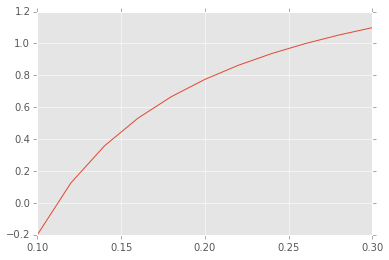

In [53]:
y = np.zeros(11)
x = np.zeros(11)
i = 0
#draw percent of a bill vs savings graph
for step in np.linspace(0.1, 0.3, num=11):
    ElectricityPriceUCDemand = step
    #call function, get percent_savings
    design = calculate_design()
    y[i] = design['net_savings_loan']
    x[i] = step
    i = i + 1
#draw graph
plt.plot(x, y)


1.5027
2.04675
2.5908
3.13485
3.6789
4.22295
4.767
5.31105
5.8551
6.39915
6.9432


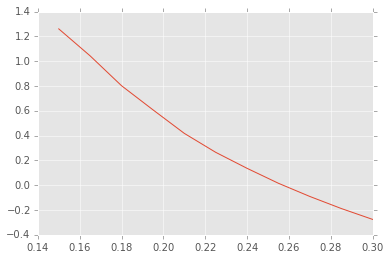

In [56]:
base_efficiency = 0.15
y = np.zeros(11)
x = np.zeros(11)
i = 0
#draw percent of a bill vs savings graph
for step in np.linspace(0.15, 0.3, num=11):
    price_per_watt = (-1.3126 + step/base_efficiency * 1.8135)*3
    print(price_per_watt)
    panel_efficiency = step
    #call function, get percent_savings
    design = calculate_design()
    y[i] = design['net_savings_loan']
    x[i] = step
    i = i + 1
#draw graph
plt.plot(x, y)

172395.0